In [2]:
import re
import numpy as np
from PIL import Image

from sklearn.model_selection import train_test_split
from keras import backend as K
from keras.layers import Activation
from keras.layers import Input, Lambda, Dense, Dropout, Convolution2D, MaxPooling2D, Flatten
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import RMSprop,Adam
from keras import optimizers

import matplotlib.image as mpimg 
import matplotlib.pyplot as plt 

from keras import callbacks
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard
import os
from keras.models import Model,load_model
import json
from keras.models import model_from_json, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
import warnings
warnings.filterwarnings('ignore')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
selected_image_size = 100 #pixel size
resize = False
total_sample_size = 10000 # 5k-50k

channel = 1
size = 2

folder_count = 131
image_count = 20 #0-50

if resize == True:
    batch_size=256
else:
    batch_size=64

path =  os.path.join('/content/drive/MyDrive/Major Project/Dataset 3/SamyakEdited/')
print(path)

/content/drive/MyDrive/Major Project/Dataset 3/SamyakEdited/


In [5]:
def read_image(filename, byteorder='>'):
    
    #first we read the image, as a raw file to the buffer
    with open(filename, 'rb') as f:

        buffer = f.read()
    
    #using regex, we extract the header, width, height and maxval of the image
    header, width, height, maxval = re.search(
        b"(^P5\s(?:\s*#.*[\r\n])*"
        b"(\d+)\s(?:\s*#.*[\r\n])*"
        b"(\d+)\s(?:\s*#.*[\r\n])*"
        b"(\d+)\s(?:\s*#.*[\r\n]\s)*)", buffer).groups()
    
    #then we convert the image to numpy array using np.frombuffer which interprets buffer as one dimensional array
    return np.frombuffer(buffer,
                            dtype='u1' if int(maxval) < 256 else byteorder+'u2',
                            count=int(width)*int(height),
                            offset=len(header)
                            ).reshape((int(height), int(width)))


def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

def contrastive_loss(y_true, y_pred):
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

def compute_accuracy(predictions, labels):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return labels[predictions.ravel() < 0.5].mean()

def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))


In [6]:
def get_data(size, total_sample_size):
    #read the image
    img = mpimg.imread(path+'S' + str(1) + '/' + str(1) + '_100.jpg', 'rw+')
    image = 0.2126*img[:,:,0] + 0.7152*img[:,:,1] + 0.0722*img[:,:,2]
    #reduce the size
    if resize == True:
        image = image[::size, ::size]
    #get the new size
    dim1 = image.shape[0]
    dim2 = image.shape[1]

    count = 0

    #initialize the numpy array with the shape of [total_sample, no_of_pairs, dim1, dim2]
    x_geuine_pair = np.zeros([total_sample_size, 2, 1, dim1, dim2])

    y_genuine = np.zeros([total_sample_size,1])

    for i in range(folder_count):
        for j in range(int(total_sample_size/folder_count)):
            ind1 = 0
            ind2 = 0

            #read images from same directory (genuine pair)
            while ind1 == ind2:
                ind1 = np.random.randint(image_count)
                ind2 = np.random.randint(image_count)

            # read the two images
            image1 = mpimg.imread(path+'S' + str(i+1) + '/' + str(ind1 + 1) + '_100.jpg', 'rw+')
            img1 = 0.2126*image1[:,:,0] + 0.7152*image1[:,:,1] + 0.0722*image1[:,:,2]
            image2 = mpimg.imread(path+'S' + str(i+1) + '/' + str(ind2 + 1) + '_100.jpg', 'rw+')
            img2 = 0.2126*image2[:,:,0] + 0.7152*image2[:,:,1] + 0.0722*image2[:,:,2]


            #store the images to the initialized numpy array
            x_geuine_pair[count, 0, 0, :, :] = img1
            x_geuine_pair[count, 1, 0, :, :] = img2

            #as we are drawing images from the same directory we assign label as 1. (genuine pair)
            y_genuine[count] = 1
            count += 1

    count = 0
    x_imposite_pair = np.zeros([total_sample_size, 2, 1, dim1, dim2])
    y_imposite = np.zeros([total_sample_size, 1])

    for i in range(int(total_sample_size/image_count)):
        for j in range(image_count):

            #read images from different directory (imposite pair)
            while True:
                ind1 = np.random.randint(folder_count)
                ind2 = np.random.randint(folder_count)
                if ind1 != ind2:
                    break
            image1 = mpimg.imread(path+'S' + str(ind1+1) + '/' + str(j + 1) + '_100.jpg', 'rw+')
            img1 = 0.2126*image1[:,:,0] + 0.7152*image1[:,:,1] + 0.0722*image1[:,:,2]
            image2 = mpimg.imread(path+'S' + str(ind2+1) + '/' + str(j + 1) + '_100.jpg', 'rw+')
            img2 = 0.2126*image2[:,:,0] + 0.7152*image2[:,:,1] + 0.0722*image2[:,:,2]


            x_imposite_pair[count, 0, 0, :, :] = img1
            x_imposite_pair[count, 1, 0, :, :] = img2
            #as we are drawing images from the different directory we assign label as 0. (imposite pair)
            y_imposite[count] = 0
            count += 1

    #now, concatenate, genuine pairs and imposite pair to get the whole data
    #print(x_geuine_pair.shape)
    #print(x_imposite_pair.shape)
    X = np.concatenate([x_geuine_pair, x_imposite_pair], axis=0)/255
    Y = np.concatenate([y_genuine, y_imposite], axis=0)

    return X, Y
    
X, Y = get_data(size, total_sample_size)

KeyboardInterrupt: ignored

In [ ]:
X.shape

In [ ]:
Y.shape

In [ ]:
X.shape

In [ ]:
Y.shape

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=.15)

In [ ]:
print('x_train',x_train.shape)
print('x_test',x_test.shape)
print('y_train',y_train.shape)
print('y_test',y_test.shape)

In [ ]:
import tensorflow as tf
from keras import backend as K
K.set_image_data_format('channels_first')
def build_base_network(input_shape):
    
    seq = tf.keras.Sequential()
    
    nb_filter = [16, 32, 16]
    kernel_size = 2
    
    
    #convolutional layer 1
    seq.add(Convolution2D(nb_filter[0], kernel_size, kernel_size, input_shape=input_shape,padding='valid'))
    seq.add(Activation('relu'))
    seq.add(MaxPooling2D(pool_size=(2, 2)))  
    seq.add(Dropout(.25))
    
    #convolutional layer 2
    seq.add(Convolution2D(nb_filter[1], kernel_size, kernel_size, padding='valid'))
    seq.add(Activation('relu'))
    seq.add(MaxPooling2D(pool_size=(2, 2))) 
    seq.add(Dropout(.25))
    
    #convolutional layer 2
    seq.add(Convolution2D(nb_filter[2], kernel_size, kernel_size, padding='valid'))
    seq.add(Activation('relu'))
    seq.add(MaxPooling2D(pool_size=(2, 2))) 
    seq.add(Dropout(.25))

    #flatten 
    seq.add(Flatten())
    seq.add(Dense(128, activation='relu'))
    seq.add(Dropout(0.1))
    seq.add(Dense(50, activation='relu'))
    return seq

In [ ]:
input_dim = x_train.shape[2:]
img_a = Input(shape=input_dim)
img_b = Input(shape=input_dim)
print('input_dim',input_dim)

In [ ]:
base_network = build_base_network(input_dim)
feat_vecs_a = base_network(img_a)
feat_vecs_b = base_network(img_b)

In [ ]:
distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([feat_vecs_a, feat_vecs_b])

In [ ]:
epochs = 20
rms = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)#RMSprop()
rms = RMSprop()

earlyStopping = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=3,
                              verbose=1,
                              restore_best_weights=True)
callback_early_stop_reduceLROnPlateau=[earlyStopping]

In [ ]:
model = Model([img_a, img_b], distance)
model.compile(loss=contrastive_loss, optimizer=rms,metrics=[accuracy])
model.summary()

In [ ]:
img_1 = x_train[:, 0]
img2 = x_train[:, 1]
img_1.shape
history = model.fit([img_1, img2], y_train, validation_split=.20,
      batch_size= batch_size, verbose=1,epochs=epochs, callbacks=callback_early_stop_reduceLROnPlateau)


In [ ]:
model.save('/content/drive/MyDrive/Major Project')

## Testing

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from keras import backend as K
K.set_image_data_format('channels_first')
new_model = load_model('/content/drive/MyDrive/Major Project/Training Files/Dataset1/One Shot Learning/Model/20220221-0927-vgg16-entire-best.h5')

In [7]:
from keras.models import model_from_json
json_file = open('/content/drive/MyDrive/Major Project/Training Files/Dataset1/One Shot Learning/Model/model_architecture (1).json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/drive/MyDrive/Major Project/Training Files/Dataset1/One Shot Learning/Model/model_weights.h5")
print("Loaded model from disk")

Loaded model from disk


In [8]:
loaded_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1, 100, 100  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 1, 100, 100  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 50)           12850       ['input_1[0][0]',                
                                                                  'input_2[0][0]']          

In [9]:
def n_way_pairs(n):
    #read the image
    img = mpimg.imread(path+'S' + str(1) + '/' + str(1) + '_100.jpg', 'rw+')
    image = 0.2126*img[:,:,0] + 0.7152*img[:,:,1] + 0.0722*img[:,:,2]
    #get the new size
    dim1 = image.shape[0]
    dim2 = image.shape[1]

    count = 0

    #initialize the numpy array with the shape of [total_sample, no_of_pairs, dim1, dim2]
    x_geuine_pair = np.zeros([1, 2, 1, dim1, dim2])

    y_genuine = np.zeros([1,1])

    ind1=np.random.randint(1,folder_count)
    image_index1=np.random.randint(1,image_count)
    image_index2=np.random.randint(1,image_count)

    image1= mpimg.imread(path+'S'+str(ind1)+'/'+str(image_index1)+'_100.jpg','rw+')
    img1 = 0.2126*image1[:,:,0] + 0.7152*image1[:,:,1] + 0.0722*image1[:,:,2]
    image2 = mpimg.imread(path+'S'+str(ind1)+'/'+str(image_index2)+'_100.jpg','rw+')
    img2 = 0.2126*image2[:,:,0] + 0.7152*image2[:,:,1] + 0.0722*image2[:,:,2]

    x_geuine_pair[0, 0, 0, :, :] = img1
    x_geuine_pair[0, 1, 0, :, :] = img2
    y_genuine[0] = 1

    x_imposite_pair = np.zeros([n-1, 2, 1, dim1, dim2])
    y_imposite = np.zeros([n-1, 1])

    count=0

    for i in range(n-1):
      while True:
        ind2=np.random.randint(1,folder_count)
        if ind1 != ind2:
          break
      image_index3=np.random.randint(1,image_count)

      image3=mpimg.imread(path+'S'+str(ind2)+'/'+str(image_index3)+'_100.jpg','rw+')
      img3=0.2126*image3[:,:,0] + 0.7152*image3[:,:,1] + 0.0722*image3[:,:,2]
      
      x_imposite_pair[count, 0, 0, :, :] = img1
      x_imposite_pair[count, 1, 0, :, :] = img3
      #as we are drawing images from the different directory we assign label as 0. (imposite pair)
      y_imposite[count] = 0
      count += 1

    #now, concatenate, genuine pairs and imposite pair to get the whole data
    #print(x_geuine_pair.shape)
    #print(x_imposite_pair.shape)
    X = np.concatenate([x_geuine_pair, x_imposite_pair], axis=0)/255
    Y = np.concatenate([y_genuine, y_imposite], axis=0)

    return X, Y

In [10]:
def n_way_accuracy(steps,n):
  k=0
  for i in range(steps):
    x_test,y_test=n_way_pairs(n)
    preds=[]
    for j in range(n):
      pred=loaded_model.predict([x_test[j:j+1, 0], x_test[j:j+1, 1]])
      preds.append(pred)
    preds=np.array(preds)
    actual_index=np.argmax(np.array(y_test))
    predicted_index=np.argmin(preds)
    if actual_index==predicted_index:
      k+=1
  accuracy=(k/steps)*100
  
  return accuracy

In [ ]:
steps=150
history=[]
for i in range(5,51,5):
  n_accuracy=n_way_accuracy(steps,i)
  history.append(n_accuracy)
  print(f"The accuracy for {i} way learning is :{n_accuracy}")

The accuracy for 5 way learning is :97.33333333333334
The accuracy for 10 way learning is :92.66666666666666
The accuracy for 15 way learning is :93.33333333333333
The accuracy for 20 way learning is :88.66666666666667
The accuracy for 25 way learning is :82.0
The accuracy for 30 way learning is :86.0
The accuracy for 35 way learning is :82.0
The accuracy for 40 way learning is :78.0


In [11]:
history=[97.33,92.66,93.33,88.66,82,86,86,78]

In [12]:
steps=150
for i in range(45,61,5):
  n_accuracy=n_way_accuracy(steps,i)
  history.append(n_accuracy)
  print(f"The accuracy for {i} way learning is :{n_accuracy}")

The accuracy for 45 way learning is :78.0
The accuracy for 50 way learning is :77.33333333333333
The accuracy for 55 way learning is :76.66666666666667
The accuracy for 60 way learning is :75.33333333333333


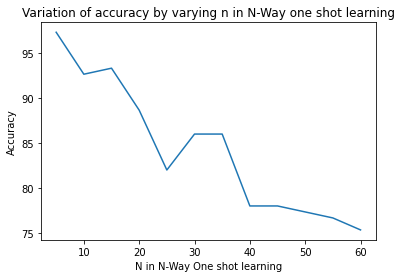

In [13]:
ns=[5,10,15,20,25,30,35,40,45,50,55,60]
plt.plot(ns, history)
plt.xlabel("N in N-Way One shot learning")
plt.ylabel("Accuracy")
plt.title('Variation of accuracy by varying n in N-Way one shot learning')
  
# Show another chart with '-' dotted line
plt.show()

In [14]:
steps=100
for i in range(65,81,5):
  n_accuracy=n_way_accuracy(steps,i)
  history.append(n_accuracy)
  print(f"The accuracy for {i} way learning is :{n_accuracy}")

The accuracy for 65 way learning is :74.0
The accuracy for 70 way learning is :71.0
The accuracy for 75 way learning is :64.0
The accuracy for 80 way learning is :68.0


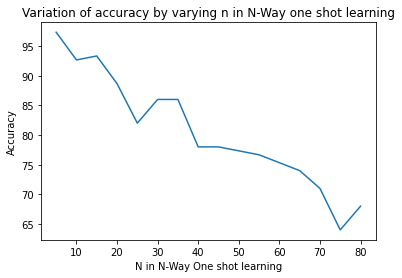

In [15]:
ns=[5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80]
plt.plot(ns, history)
plt.xlabel("N in N-Way One shot learning")
plt.ylabel("Accuracy")
plt.title('Variation of accuracy by varying n in N-Way one shot learning')
  
# Show another chart with '-' dotted line
plt.show()